In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from google.cloud import storage
import itertools
import pickle
from google.cloud import storage


In [36]:
# Crear una instancia del cliente BigQuery usando el archivo de credenciales JSON
credentials_path = 'C:/Users/NoxiePC/Desktop/henry/driven-atrium-445021-m2-a773215c2f46.json'
credentials = service_account.Credentials.from_service_account_file(credentials_path)

# Crear el cliente BigQuery con las credenciales
client = bigquery.Client(credentials=credentials, project=credentials.project_id)
#client = bigquery.Client()

# Definir la consulta SQL para acceder a la vista
query_viajes_por_ubicacion_y_tiempoPU = """SELECT * FROM `driven-atrium-445021-m2.project_data.viajes_por_ubicacion_y_tiempo`;"""
query_viajes_por_ubicacion_y_tiempoDO = """SELECT * FROM `driven-atrium-445021-m2.project_data.oferta_por_ubicacion` ;"""
query_weather_borough_details = """SELECT * FROM `driven-atrium-445021-m2.project_data.weather_borough_details`;"""
query_coordinates = """SELECT location_id, borough FROM driven-atrium-445021-m2.project_data.coordinates"""

# Ejecutar la consulta y cargar los resultados en un DataFrame de pandas
df_coordinates = client.query(query_coordinates).to_dataframe()
df_clima = client.query(query_weather_borough_details).to_dataframe()
df_viajesPU = client.query(query_viajes_por_ubicacion_y_tiempoPU).to_dataframe()
df_viajesDO = client.query(query_viajes_por_ubicacion_y_tiempoDO).to_dataframe()


c:\Users\NoxiePC\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1785: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
c:\Users\NoxiePC\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1785: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
c:\Users\NoxiePC\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1785: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
c:\Users\NoxiePC\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1785: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [64]:
clima = df_clima
viajesPU = df_viajesPU
viajesDO = df_viajesDO

In [68]:
# DEJAMOS LISTA EL DATASET DE COORDENADAS  
coordinates = df_coordinates[~df_coordinates['location_id'].isin([264, 265, 1])]
boroughs = ["Queens", "Brooklyn", "Manhattan", "Bronx", "Staten Island"]
coordinates = coordinates[coordinates['borough'].isin(boroughs)]
coordinates = coordinates.rename(columns={'location_id':'locationID'})
coordinates


,locationID,borough
1,3,Bronx
2,18,Bronx
3,20,Bronx
4,31,Bronx
5,32,Bronx
...,...,...
258,206,Staten Island
259,214,Staten Island
260,221,Staten Island
261,245,Staten Island


In [69]:
# CREAMOS EL DATASET AUXILIAR 
locaciones = coordinates['locationID'].unique()

clima = clima.rename(columns={'day_of_month':'day', 'hour_of_day':'hour'})
df = pd.DataFrame()
df['datetime'] = pd.to_datetime(clima[['year', 'month', 'day', 'hour']])
min_date = df['datetime'].min()
max_date = df['datetime'].max()

date_range = pd.date_range(start=min_date, end=max_date, freq='h')
df_aux = pd.DataFrame(date_range, columns=['datetime'])
clima = clima.rename(columns={'day':'day_of_month', 'hour':'hour_of_day'})

In [70]:
# PONER TODAS LAS TABLAS EN EL MISMO RANGO DE FECHAS 
viajesDO = viajesDO.rename(columns={'day_of_month':'day', 'hour_of_day':'hour'})
viajesPU = viajesPU.rename(columns={'day_of_month':'day', 'hour_of_day':'hour'})

viajesDO['datetime'] = pd.to_datetime(viajesDO[['year', 'month', 'day', 'hour']])
viajesPU['datetime'] = pd.to_datetime(viajesPU[['year', 'month', 'day', 'hour']])

viajesDO = viajesDO[viajesDO['datetime'].isin(date_range)]
viajesPU = viajesPU[viajesPU['datetime'].isin(date_range)]

viajesDO = viajesDO.drop(columns=['datetime'])
viajesPU = viajesPU.drop(columns=['datetime'])

viajesDO = viajesDO.rename(columns={'day':'day_of_month', 'hour':'hour_of_day'})
viajesPU = viajesPU.rename(columns={'day':'day_of_month', 'hour':'hour_of_day'})

In [71]:
df_aux = list(itertools.product(df_aux['datetime'], locaciones))
df_aux = pd.DataFrame(df_aux, columns=['datetime', 'locationID'])

In [72]:
df_aux['year'] = df_aux['datetime'].dt.year
df_aux['month'] = df_aux['datetime'].dt.month
df_aux['day_of_month'] = df_aux['datetime'].dt.day
df_aux['hour_of_day'] = df_aux['datetime'].dt.hour
df_aux['day_of_week'] = df_aux['datetime'].dt.dayofweek
df_aux = df_aux.drop(columns=['datetime'])

In [95]:
day_of_week_mapping = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 0: 6}

viajesDO['day_of_week'] = viajesDO['day_of_week'].replace(day_of_week_mapping)

In [96]:
resultado = pd.DataFrame()

resultado = df_aux.merge(viajesDO, on=['locationID', 'year', 'month', 'day_of_month', 'hour_of_day', 'day_of_week'], how='left')
resultado['oferta'] = resultado['oferta'].fillna(0)
resultado = resultado.merge(viajesPU, on=['locationID', 'year', 'month', 'day_of_month', 'hour_of_day', 'day_of_week'], how='left')
resultado['solicitudes'] = resultado['solicitudes'].fillna(0)
resultado['promedio_fare_amount'] = resultado['promedio_fare_amount'].fillna(0)


In [97]:
trip_data = resultado

In [99]:

#  # Realizar el merge para agregar la columna 'Borough' al dataset 'trip_data' 
trip_data = trip_data.merge(coordinates[['locationID', 'borough']], on='locationID', how='left')
trip_data = trip_data.merge(clima, on=['year', 'month', 'day_of_month', 'hour_of_day', 'day_of_week', 'borough'], how='left')

trip_data

,locationID,year,month,day_of_month,hour_of_day,day_of_week,oferta,solicitudes,promedio_fare_amount,borough,temperature,relative_humidity,apparent_temperature,weather_code,cloud_cover,wind_speed,wind_gusts
0,3,2023,1,1,0,6,49,59,25.696441,Bronx,10.8,98.0,9.9,55.0,100.0,8.0,22.3
1,18,2023,1,1,0,6,176,236,21.692288,Bronx,10.8,98.0,9.9,55.0,100.0,8.0,22.3
2,20,2023,1,1,0,6,81,95,21.002105,Bronx,10.8,98.0,9.9,55.0,100.0,8.0,22.3
3,31,2023,1,1,0,6,8,10,23.713000,Bronx,10.8,98.0,9.9,55.0,100.0,8.0,22.3
4,32,2023,1,1,0,6,87,115,25.002870,Bronx,10.8,98.0,9.9,55.0,100.0,8.0,22.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4212955,206,2024,10,31,23,3,65,57,17.899825,Staten Island,21.3,63.0,19.4,3.0,100.0,22.2,39.6
4212956,214,2024,10,31,23,3,22,27,17.871852,Staten Island,21.3,63.0,19.4,3.0,100.0,22.2,39.6
4212957,221,2024,10,31,23,3,38,48,19.935000,Staten Island,21.3,63.0,19.4,3.0,100.0,22.2,39.6
4212958,245,2024,10,31,23,3,31,26,18.947692,Staten Island,21.3,63.0,19.4,3.0,100.0,22.2,39.6


In [137]:
trip_data.to_parquet('trip_data.parquet', engine='pyarrow')

In [ ]:
"""trip_data.isnull().sum()
# Contar la cantidad de ceros en cada columna de interés
count_zeros_solicitudes = (trip_data['solicitudes'] == 0).sum()
count_zeros_oferta = (trip_data['oferta'] == 0).sum()
count_zeros_promedio_fare_amount = (trip_data['promedio_fare_amount'] == 0).sum()

print(f"Cantidad de ceros en 'solicitudes': {count_zeros_solicitudes}")
print(f"Cantidad de ceros en 'oferta': {count_zeros_oferta}")
print(f"Cantidad de ceros en 'promedio_fare_amount': {count_zeros_promedio_fare_amount}")"""


Cantidad de ceros en 'solicitudes': 166786
Cantidad de ceros en 'oferta': 153889
Cantidad de ceros en 'promedio_fare_amount': 168552


In [146]:
import numpy as np

# Crear una máscara booleana aleatoria para seleccionar el 50% de los datos
mask = np.random.rand(len(trip_data)) < 0.1
trip_data_reduced = trip_data[mask]

print(f"Original DataFrame size: {len(trip_data)}")
print(f"Reduced DataFrame size: {len(trip_data_reduced)}")

Original DataFrame size: 4212960
Reduced DataFrame size: 420869


In [149]:
# Variables predictoras (X) y variable objetivo (y)
predictors = [
    'locationID', 'day_of_month','hour_of_day', 'day_of_week',
    'relative_humidity', 'apparent_temperature','temperature', 'weather_code',
    'cloud_cover','wind_speed', 'wind_gusts'
]

X = trip_data_reduced[predictors]
y1 = trip_data_reduced['solicitudes']
y2 = trip_data_reduced['oferta']
y3 = trip_data_reduced['promedio_fare_amount']

# Dividir los datos en conjunto de entrenamiento y prueba (80% entrenamiento, 20% prueba)
#X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=42)
#X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=42)
X_train, X_test, y3_train, y3_test = train_test_split(X, y3, test_size=0.2, random_state=42)

# Crear el modelo XGBoost
"""model_1 = xgb.XGBRegressor(
    n_estimators=80,
    max_depth=15,
    learning_rate=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model_2 = xgb.XGBRegressor(
    n_estimators=80,
    max_depth=15,
    learning_rate=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)"""
model_3 = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=20,
    learning_rate=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Entrenar el modelo con los datos de entrenamiento
#model_1.fit(X_train, y1_train)
#model_2.fit(X_train, y2_train)
model_3.fit(X_train, y3_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [124]:
cross_val = [2025.49, 2124.25, 1615.32, 1551.15, 1227.40, 1221.76, 1232.69, 1983.91,1602.33]
cross_val_dispersion = [362.30, 785.33, 545.70, 612.91, 95.90, 125.25, 115.63, 647.20, 783.20]
mse = [1644.47, 1304.11, 1281.12, 1453.77, 1108.69, 1323.94, 1068.85, 2623.09, 3176.98]
mae = [20.82, 18.80, 18.29, 18.80, 17.10, 17.75, 16.90, 19.80, 19.48]
r2 = [0.93, 0.95, 0.95, 0.94, 0.95, 0.95, 0.96, 0.89, 0.87]

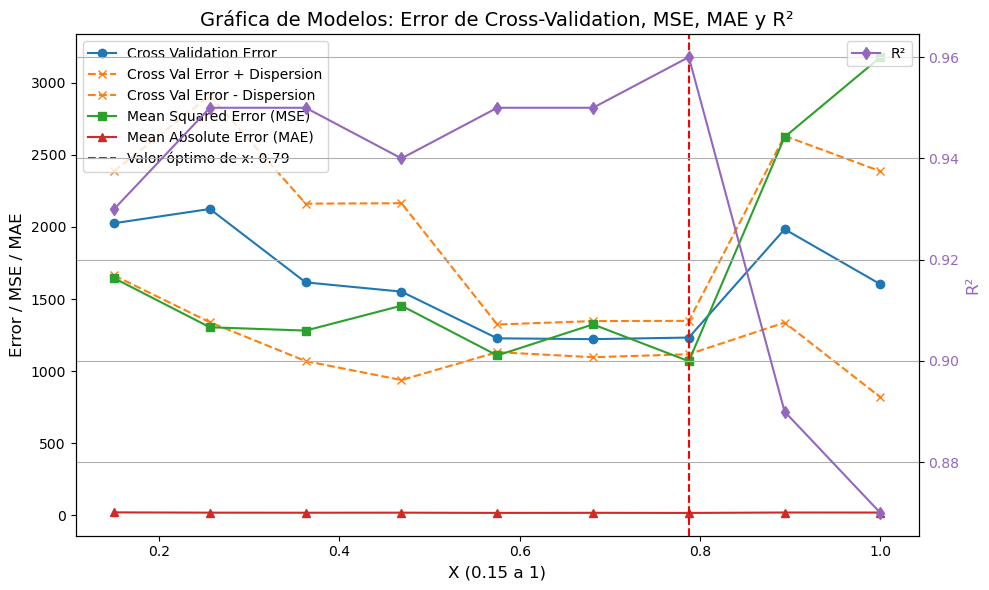

In [133]:
import matplotlib.pyplot as plt
import numpy as np

# Datos proporcionados
cross_val = [2025.49, 2124.25, 1615.32, 1551.15, 1227.40, 1221.76, 1232.69, 1983.91, 1602.33]
cross_val_dispersion = [362.30, 785.33, 545.70, 612.91, 95.90, 125.25, 115.63, 647.20, 783.20]
mse = [1644.47, 1304.11, 1281.12, 1453.77, 1108.69, 1323.94, 1068.85, 2623.09, 3176.98]
mae = [20.82, 18.80, 18.29, 18.80, 17.10, 17.75, 16.90, 19.80, 19.48]
r2 = [0.93, 0.95, 0.95, 0.94, 0.95, 0.95, 0.96, 0.89, 0.87]

# Eje X: valores entre 0.15 y 1 (ajustados a la cantidad de datos)
x = np.linspace(0.15, 1, len(cross_val))

# Encontrar el índice del valor óptimo (R² máximo)
index_optimo = np.argmax(r2)  # Obtener el índice donde R² es máximo
x_optimo = x[index_optimo]  # Valor de x correspondiente al máximo R²

# Crear la figura y el eje
fig, ax1 = plt.subplots(figsize=(10, 6))

# Graficar los valores de cross_val
ax1.plot(x, cross_val, label="Cross Validation Error", marker='o', color='tab:blue')

# Graficar los puntos de "cross_val + dispersion" y "cross_val - dispersion"
ax1.plot(x, np.array(cross_val) + np.array(cross_val_dispersion), label="Cross Val Error + Dispersion", linestyle="--", marker='x', color='tab:orange')
ax1.plot(x, np.array(cross_val) - np.array(cross_val_dispersion), label="Cross Val Error - Dispersion", linestyle="--", marker='x', color='tab:orange')

# Graficar los otros valores como antes
ax1.plot(x, mse, label="Mean Squared Error (MSE)", marker='s', color='tab:green')
ax1.plot(x, mae, label="Mean Absolute Error (MAE)", marker='^', color='tab:red')

# Etiquetas para el primer eje Y
ax1.set_xlabel('X (0.15 a 1)', fontsize=12)
ax1.set_ylabel('Error / MSE / MAE', fontsize=12, color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Crear el segundo eje Y para el R²
ax2 = ax1.twinx()
ax2.plot(x, r2, label="R²", marker='d', color='tab:purple')

# Etiquetas para el segundo eje Y
ax2.set_ylabel('R²', fontsize=12, color='tab:purple')
ax2.tick_params(axis='y', labelcolor='tab:purple')

# Marcar el valor óptimo con una línea vertical
ax1.axvline(x_optimo, color='red', linestyle='--', label=f'Valor óptimo de x: {x_optimo:.2f}')

# Título de la gráfica
plt.title('Gráfica de Modelos: Error de Cross-Validation, MSE, MAE y R²', fontsize=14)

# Mostrar leyenda
fig.tight_layout()  # Ajustar para que no se sobrepongan las leyendas
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar la gráfica
plt.grid(True)
plt.show()


Cross-Validation MSE: 44.279110231732574 ± 13.057879405805757
Mean Squared Error (MSE): 36.18017176597017
Mean Absolute Error (MAE): 3.3935550472128653
R² Score: 0.4779910366966006
Importancia de las Características:
locationID              0.209978
wind_gusts              0.117093
hour_of_day             0.088409
wind_speed              0.086132
weather_code            0.080240
cloud_cover             0.076599
apparent_temperature    0.073439
temperature             0.073173
day_of_month            0.068217
day_of_week             0.067693
relative_humidity       0.059028
dtype: float32


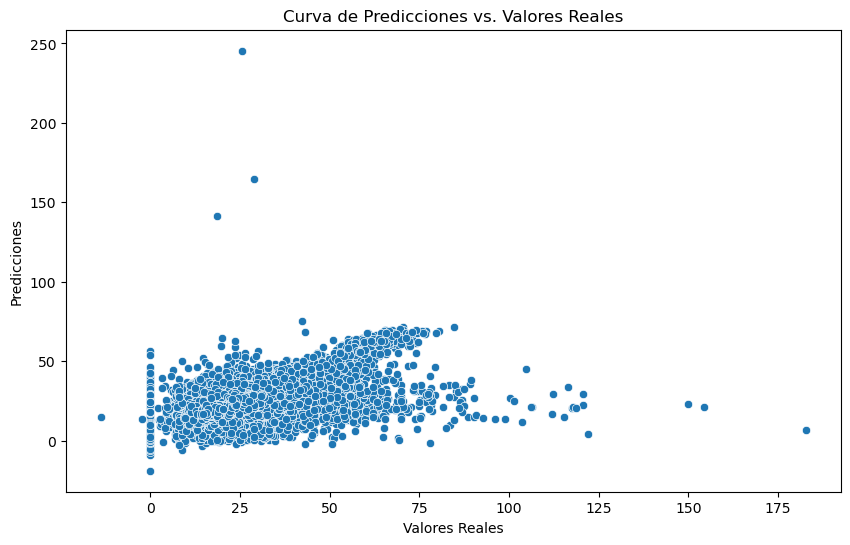

In [150]:
# Validación cruzada para evaluar el modelo
scores = cross_val_score(model_3, X_train, y3_train, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validation MSE: {-scores.mean()} ± {scores.std()}")

# Predecir con los datos de prueba
y3_pred = model_3.predict(X_test)

mse = mean_squared_error(y3_test, y3_pred)
mae = mean_absolute_error(y3_test, y3_pred)
r2 = r2_score(y3_test, y3_pred)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

importancia_caracteristicas = pd.Series(model_3.feature_importances_, index=predictors).sort_values(ascending=False)
print("Importancia de las Características:")
print(importancia_caracteristicas)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y3_test, y=y3_pred)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Curva de Predicciones vs. Valores Reales")
plt.show()

In [ ]:
bucket_name = 'nombre-del-bucket'
model_1_filename = 'model_1.pkl'
model_2_filename = 'model_2.pkl'
model_3_filename = 'model_3.pkl'

storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)

def save_model_to_bucket(model, model_filename):

    model_data = pickle.dumps(model)
    blob = bucket.blob(model_filename)  # Crear un blob (objeto) en el bucket con el nombre del archivo    
    blob.upload_from_string(model_data)  # Subir los datos del modelo al bucket

save_model_to_bucket(model_1, model_1_filename)
save_model_to_bucket(model_2, model_2_filename)
save_model_to_bucket(model_3, model_3_filename)

print("Modelos guardados exitosamente en el bucket.")
